<a href="https://colab.research.google.com/github/patel-zeel/adain_repl/blob/first_attempt/attn_AQ_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Concatenate, Lambda, Multiply, Reshape, Input, Dropout, Attention, Flatten

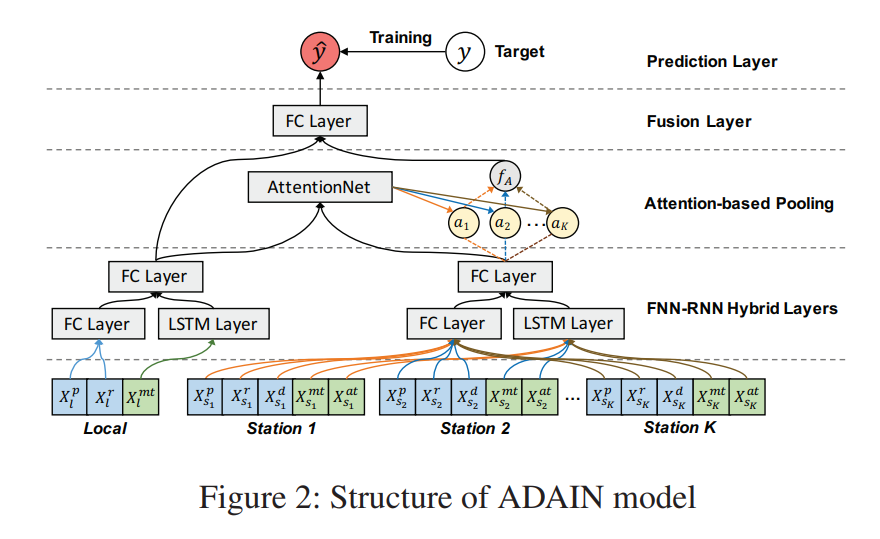

In [ ]:
local_fc_dim = [1,6]
local_lstm_dim = [24,6]

local_inputs1d_poi = Input(shape=local_fc_dim)
local_inputs1d_road = Input(shape=[1,4])
local_inputs2d = Input(shape=local_lstm_dim)

fc_input = Concatenate()([local_inputs1d_poi, local_inputs1d_road])  
local_fc_layer = Dense(100,activation='relu')(fc_input) 
local_fc_layer = Flatten()(local_fc_layer)

local_lstm_layer = LSTM(300,activation='relu',return_sequences=True)(local_inputs2d)
local_lstm_layer2 = LSTM(300,activation='relu')(local_lstm_layer)
upsample_lstm = Dense(200,activation='relu')(local_lstm_layer2) 

local_output1 = Concatenate()([local_fc_layer, local_lstm_layer2])

local_dense_layer1 = Dense(200,activation='relu')(local_output1)
local_dense_layer2 = Dense(200,activation='relu')(local_dense_layer1)


In [ ]:
Xp = Input(shape=local_fc_dim)
Xr = Input(shape=local_fc_dim)
Xd = Input(shape=local_fc_dim)

Xm = Input(shape=local_lstm_dim)
Xa = Input(shape=local_lstm_dim)

In [ ]:
station_list = []
attn_list = []
no_stations = 2
for n in range(no_stations):
  # define Xp, Xr, Xd, Xm, Xa according to station
  Xprd = Concatenate()([Xp,Xr,Xd])
  Xma = Concatenate()([Xm,Xa])

  station_fc_input = Concatenate()([Xprd])
  station_lstm_input = Concatenate()([Xma])

  station_fc_layer = Dense(100,activation='relu')(station_fc_input)
  station_lstm_layer = LSTM(300,activation='relu',return_sequences=True)(station_lstm_input )
  station_lstm_layer2 = LSTM(300,activation='relu')(station_lstm_layer)

  station_fc_layer = Flatten()(station_fc_layer)

  station_output1 = Concatenate()([station_fc_layer, station_lstm_layer2])

  station_dense_layer1 = Dense(200,activation='relu')(station_output1)
  station_dense_layer2 = Dense(200,activation='relu')(station_dense_layer1)
  # station_downsamples = Dense(1,activation='relu')(station_dense_layer2)

  Attn_1 = Dense(200, activation='relu')(Concatenate()([local_dense_layer2, station_dense_layer2]))
  Attn_2 = Dense(200)(Attn_1)
  Attn_3 = Dense(1,activation='softmax')(Attn_2)

  station_list.append(station_dense_layer2)
  attn_list.append(Attn_3)

fmul_list = []
for i in range(len(station_list)):
  fmul_element = Multiply()([station_list[i], attn_list[i]]) 
  fmul_list.append(fmul_element)

fmul = Concatenate()(fmul_list)

fA = Lambda(lambda x: K.sum(x,axis=1))(fmul)

fA = tf.reshape(fA,tf.shape(in_downsample)) 

final_input = Concatenate()([local_dense_layer2,fA])
final_fc_layer = Dense(200, activation='relu')(final_input)
output = Dense(1, activation='relu')(final_fc_layer)
